In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from pneumoniacnn import PneumoniaCNN
import utils as uti

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [2]:
# Set paths
data_dir = '../data/chest_xray'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

# Define transforms
train_transform, test_transform, __ =  uti.transform_imgs()

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=test_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)

In [3]:
class RandomLabelDataset(Dataset):
    def __init__(self, original_dataset, num_classes=2, random_seed=42):
        """
        Creates a dataset with randomized labels from an existing dataset
        
        Args:
            original_dataset: The source dataset, each item should be (tensor, label)
            num_classes: Number of classes in the dataset
            random_seed: Seed for reproducibility
        """
        self.original_dataset = original_dataset
        self.num_classes = num_classes
        
        # Set random seed for reproducibility
        random.seed(random_seed)
        
        # Generate random labels
        self.random_labels = [random.randint(0, num_classes-1) for _ in range(len(original_dataset))]
        
        # Print some statistics
        original_labels = [original_dataset[i][1] for i in range(min(len(original_dataset), 1000))]
        class_distribution = {}
        random_distribution = {}
        
        for label in original_labels:
            if label in class_distribution:
                class_distribution[label] += 1
            else:
                class_distribution[label] = 1
                
        for label in self.random_labels[:1000]:
            if label in random_distribution:
                random_distribution[label] += 1
            else:
                random_distribution[label] = 1
        
        print(f"Original class distribution (first 1000): {class_distribution}")
        print(f"Random class distribution (first 1000): {random_distribution}")
    
    def __getitem__(self, index):
        # Get the data tensor from the original dataset but use our random label
        data, _ = self.original_dataset[index]
        return data, self.random_labels[index]
    
    def __len__(self):
        return len(self.original_dataset)

In [4]:
randomized_train_dataset = RandomLabelDataset(train_dataset, num_classes=2)

Original class distribution (first 1000): {0: 1000}
Random class distribution (first 1000): {0: 486, 1: 514}


In [5]:
# Create dataloaders
batch_size = 32
train_loader = DataLoader(randomized_train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [6]:
# Class distribution
train_counts = uti.count_class_dist(randomized_train_dataset)

# Calculate class weights for imbalanced dataset
class_weights = torch.FloatTensor([len(randomized_train_dataset)/train_counts[0], len(randomized_train_dataset)/train_counts[1]]).to(device)

# Initialize a new model for randomized training
randomized_model = PneumoniaCNN()
randomized_model.to(device)

model_name = 'randomized_pneumonia_model'

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)  # Using weighted loss for imbalanced classes
optimizer = optim.Adam(randomized_model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

# Train the randomized model
randomized_model = uti.train_model(randomized_model, randomized_train_dataset, train_loader, val_dataset, val_loader, \
                                   criterion, optimizer, scheduler, model_name, device, num_epochs=10)

# Save the randomized model for later use
torch.save({
    'model_state_dict': randomized_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'class_names': train_dataset.classes,
}, 'cnn/' + model_name + '.pth')

print("Randomized model saved successfully!")

Training set - Normal: 2573, Pneumonia: 2643
Class weights - Normal: 2.0272055965798677, Pneumonia: 1.9735149451381007
Epoch 1/10
----------
Train Loss: 1.4068 Acc: 0.4933
Val Loss: 0.6848 Acc: 0.5000
Saved best model!
Epoch 2/10
----------
Train Loss: 0.6942 Acc: 0.5059
Val Loss: 0.6908 Acc: 0.5625
Epoch 3/10
----------
Train Loss: 0.6946 Acc: 0.4902
Val Loss: 0.6924 Acc: 0.5000
Epoch 4/10
----------
Train Loss: 0.6934 Acc: 0.4971
Val Loss: 0.6933 Acc: 0.5000
Epoch 5/10
----------
Train Loss: 0.6931 Acc: 0.4931
Val Loss: 0.6925 Acc: 0.5000
Epoch 6/10
----------
Train Loss: 0.6938 Acc: 0.4937
Val Loss: 0.6948 Acc: 0.5000
Epoch 7/10
----------
Train Loss: 0.6935 Acc: 0.4946
Val Loss: 0.6931 Acc: 0.5000
Epoch 8/10
----------
Train Loss: 0.6929 Acc: 0.4948
Val Loss: 0.6929 Acc: 0.5000
Epoch 9/10
----------
Train Loss: 0.6929 Acc: 0.5010
Val Loss: 0.6928 Acc: 0.3750
Epoch 10/10
----------
Train Loss: 0.6929 Acc: 0.5036
Val Loss: 0.6937 Acc: 0.4375
Training complete in 21m 57s
Randomized mo


Test Set Performance Metrics:
Accuracy: 0.6266
Precision: 0.6268
Recall: 0.9949
F1 Score: 0.7691


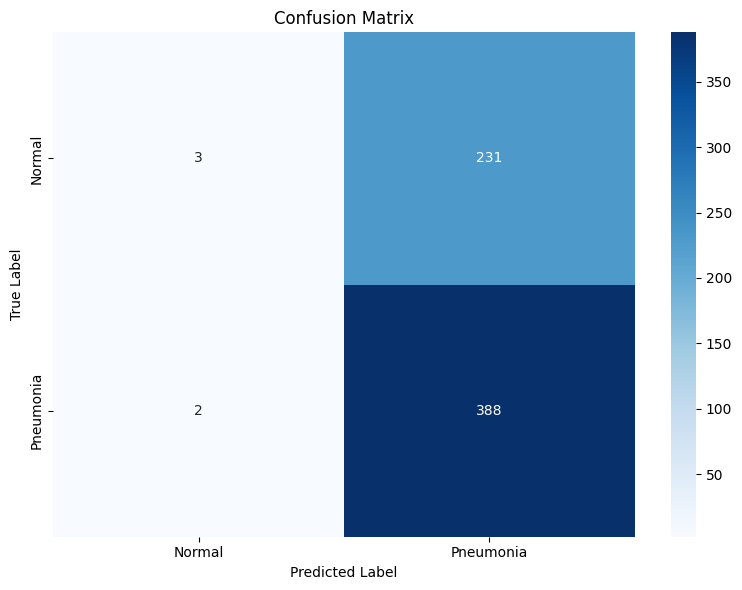

In [7]:
# Evaluate on test set
test_metrics = uti.evaluate_model(randomized_model, test_loader, device, model_name)